# Experiment 2
## Comparing the different variants of TF and IDF
Name: Xin Wei Lam<br>
Username: xl00751<br>
URN: 6525195

I chose TFIDF itself as my experiment instead of comparing Bag-of-Words/Word Vectors with/without TFIDF as BoW gives each word an equal weightage, which gives irrelevant words the same weightage as relevant words; thus using TFIDF would produce a better result most of the time. However, I am not certain that my assumption is correct, thus I have compared classifiers with and without TFIDF in experiment 4.

For this experiment, unfortunately, sklearn's TFIDF implementation was the only library implementation I could find, so I compared the TFIDF hyperparameters of smooth_idf, sublinear_tf, and normalization as I wanted to determine if normalization affected smoothing IDF and sublinear TF. 
***
### Sublinear Term Frequency
Referencing "Scoring, term weighting, and the vector space model" by Manning, C.D.; Raghavan, P.; Schutze, H (https://nlp.stanford.edu/IR-book/pdf/06vect.pdf), sublinear TF scaling applies weight to relevant TF by using the logarithm of TF, as given by:

$$wf_t,_d = \{ \begin{matrix} 1+log tf_t,_d & if tf_t,_d >0 \\ 0 & otherwise \end{matrix}$$

It is preferred over TF without scaling or normalization as in real-world scenarios, referencing the same book, "It seems unlikely that twenty occurrences of a term in a document truly carry twenty times the significance of a single occurrence."

### Smoothing Inverse Term Frequency
Smoothing is a method of removing noise from data to strengthen patterns between data. sklearn's implementation achieves this by adding 1 to its IDF calculation. The documentation only states that its purpose is to prevent zero division.

Based on these, I expect TFIDF with both sublinear TF and smooth IDF to perform better than without.

In [1]:
import keras
import numpy as np
import pandas as pd
import pickle
import sklearn
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# File paths

# Data Directory
DATA_DIR = "data"

# Balanced datasets
BALANCED_TRAIN_DATASET = "data/balanced_dataset.pickle"
BALANCED_TEST_DATASET = "data/balanced_test_dataset.pickle"

# Preprocessed balanced data
PREPROCESSED_BAL_TRAIN_DATASET = "data/preprocessed_train.pickle"
PREPROCESSED_BAL_TEST_DATASET = "data/preprocessed_test.pickle"

In [3]:
# Function to load pickle file
# Params:
    # Str - @file_path: File path of pickle file
# Output:
    # Saved object in original file type (list/dataframe)
def load_pickle(file_path):
    return pickle.load(open(file_path, "rb"))

In [4]:
# Get preprocessed train dataset
bal_train_dataset = load_pickle(PREPROCESSED_BAL_TRAIN_DATASET)

# Get preprocessed test dataset
bal_test_dataset = load_pickle(PREPROCESSED_BAL_TEST_DATASET)

# Get train_y
bal_train_y = pd.read_pickle(BALANCED_TRAIN_DATASET)
bal_train_y = bal_train_y.drop(columns="comment_text")

# Get test_y
bal_test_y = pd.read_pickle(BALANCED_TEST_DATASET)
bal_test_y = bal_test_y.drop(columns="comment_text")

In [5]:
# Constants for keras model
NUM_WORDS = 20000
MAX_LEN = 100

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Dropout, Conv1D, GlobalMaxPooling1D, Embedding

# Modified from basic model
# Params:
#   Int - @n_features: Number of features from TfidfVectorizer
# Output:
#   Model
def modified_build_model(n_features):
    EPOCHS = 30
    INIT_LR = 1e-3

    model = Sequential()

    #model.add(Embedding(num_words, 128))
    model.add(keras.Input(shape=(n_features, 1)))
    model.add(Dropout(0.4))
    model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
    model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='sigmoid'))

    adam = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

    model.compile(loss='binary_crossentropy',
                optimizer=adam,
                metrics=['accuracy'])

    return model

# sklearn TfidfVectorizer

In [7]:
# Function to return itself, just to make sure TfidfVectorizer doesn't attempt to tokenize and preprocess my preprocessed tokens
def fake_function(comments):
    return comments

Since I will be comparing variants of TF and IDF, the parameters I will be changing for TfidfVectorizer and their default values are as follows: 

* norm='l2'
* smooth_idf=True
* sublinear_tf=False 

In [8]:
# Vectorize datasets according to the TfidfVectorizer object
# Params:
#   TfidfVectorizer - @tfidf: TfidfVectorizer object
#   List            - @train_data:  Preprocessed train dataset
#   List            - @test_data:   Preprocessed test dataset
# Output:
#   Numpy array - @train_x: Numpy array conversion of (SciPy sparse matrix) document term matrix of train dataset
#   Numpy array - @test_x:  Numpy array conversion of (SciPy sparse matrix) document term matrix of test dataset
def vectorize(tfidf, train_data, test_data):

    # Fit to vocabulary and transform
    train_x = tfidf.fit_transform(train_data).toarray()
    # Transform
    test_x = tfidf.transform(test_data).toarray()

    return train_x, test_x

# Normalization L2
## Without both smooth_idf and sublinear_tf

In [9]:
tfidf_l2 = TfidfVectorizer(analyzer='word', tokenizer=fake_function, preprocessor=fake_function, token_pattern=None, min_df = 5, norm='l2', smooth_idf=False, sublinear_tf=False)

# Get vectors of train and test datasets
l2_train_x, l2_test_x = vectorize(tfidf_l2, bal_train_dataset, bal_test_dataset)

tfidf_l2_vocab = tfidf_l2.vocabulary_
tfidf_l2_reversed_vocab = {index:word for word, index in tfidf_l2_vocab.items()}

tfidf_l2_features = tfidf_l2.get_feature_names()

print(len(tfidf_l2_features))
print(tfidf_l2_features[:10])

3819
['abandon', 'abc', 'abide', 'ability', 'able', 'abortion', 'absence', 'absolute', 'absolutely', 'absurd']


In [10]:
# Pad for model & evaluation
l2_train_x = np.expand_dims(l2_train_x, -1)
l2_test_x = np.expand_dims(l2_test_x, -1)

print(l2_train_x.shape)
print(l2_test_x.shape)

(7132, 3819, 1)
(6978, 3819, 1)


In [11]:
# Train model
model = modified_build_model(len(tfidf_l2_features))

model.fit(l2_train_x, bal_train_y, batch_size=60, epochs=30)

# Save model to use for evaluation
model.save('models/exp2_tfidf_l2')

Epoch 1/30
119/119 [==============================] - 17s 56ms/step - loss: 0.5994 - accuracy: 0.2222
Epoch 2/30
119/119 [==============================] - 6s 48ms/step - loss: 0.5356 - accuracy: 0.3378
Epoch 3/30
119/119 [==============================] - 5s 42ms/step - loss: 0.5344 - accuracy: 0.3455
Epoch 4/30
119/119 [==============================] - 5s 43ms/step - loss: 0.5281 - accuracy: 0.3433
Epoch 5/30
119/119 [==============================] - 5s 43ms/step - loss: 0.5232 - accuracy: 0.3777
Epoch 6/30
119/119 [==============================] - 5s 43ms/step - loss: 0.5217 - accuracy: 0.3658
Epoch 7/30
119/119 [==============================] - 5s 43ms/step - loss: 0.5270 - accuracy: 0.4557
Epoch 8/30
119/119 [==============================] - 5s 43ms/step - loss: 0.5250 - accuracy: 0.3998
Epoch 9/30
119/119 [==============================] - 5s 45ms/step - loss: 0.5172 - accuracy: 0.4135
Epoch 10/30
119/119 [==============================] - 5s 46ms/step - loss: 0.5174 - accur

## With smooth_idf, without sublinear_tf

In [11]:
tfidf_l2_smooth = TfidfVectorizer(analyzer='word', tokenizer=fake_function, preprocessor=fake_function, token_pattern=None, min_df = 5, norm='l2', smooth_idf=True, sublinear_tf=False)

# Get vectors of train and test datasets
l2_train_x, l2_smooth_test_x = vectorize(tfidf_l2_smooth, bal_train_dataset, bal_test_dataset)

tfidf_l2_vocab = tfidf_l2_smooth.vocabulary_
tfidf_l2_reversed_vocab = {index:word for word, index in tfidf_l2_vocab.items()}

tfidf_l2_features = tfidf_l2_smooth.get_feature_names()

print(len(tfidf_l2_features))
print(tfidf_l2_features[:10])

3819
['abandon', 'abc', 'abide', 'ability', 'able', 'abortion', 'absence', 'absolute', 'absolutely', 'absurd']


In [12]:
# Pad for model & evaluation
l2_train_x = np.expand_dims(l2_train_x, -1)
l2_smooth_test_x = np.expand_dims(l2_smooth_test_x, -1)

print(l2_train_x.shape)
print(l2_smooth_test_x.shape)

(7132, 3819, 1)
(6978, 3819, 1)


In [14]:
# Train model
model = modified_build_model(len(tfidf_l2_features))

model.fit(l2_train_x, bal_train_y, batch_size=60, epochs=30)

# Save model to use for evaluation
model.save('models/exp2_tfidf_l2_smooth')

Epoch 1/30
119/119 [==============================] - 6s 40ms/step - loss: 0.5995 - accuracy: 0.2516
Epoch 2/30
119/119 [==============================] - 5s 40ms/step - loss: 0.5405 - accuracy: 0.3400
Epoch 3/30
119/119 [==============================] - 5s 41ms/step - loss: 0.5259 - accuracy: 0.3459
Epoch 4/30
119/119 [==============================] - 5s 39ms/step - loss: 0.5272 - accuracy: 0.3460
Epoch 5/30
119/119 [==============================] - 5s 42ms/step - loss: 0.5265 - accuracy: 0.3784
Epoch 6/30
119/119 [==============================] - 5s 39ms/step - loss: 0.5225 - accuracy: 0.3873
Epoch 7/30
119/119 [==============================] - 5s 40ms/step - loss: 0.5239 - accuracy: 0.3814
Epoch 8/30
119/119 [==============================] - 5s 40ms/step - loss: 0.5202 - accuracy: 0.4034
Epoch 9/30
119/119 [==============================] - 5s 39ms/step - loss: 0.5157 - accuracy: 0.4142
Epoch 10/30
119/119 [==============================] - 5s 40ms/step - loss: 0.5119 - accura

## Without smooth_idf, with sublinear_tf

In [13]:
tfidf_l2_sublinear = TfidfVectorizer(analyzer='word', tokenizer=fake_function, preprocessor=fake_function, token_pattern=None, min_df = 5, norm='l2', smooth_idf=False, sublinear_tf=True)

# Get vectors of train and test datasets
l2_train_x, l2_sub_test_x = vectorize(tfidf_l2_sublinear, bal_train_dataset, bal_test_dataset)

tfidf_l2_vocab = tfidf_l2_sublinear.vocabulary_
tfidf_l2_reversed_vocab = {index:word for word, index in tfidf_l2_vocab.items()}

tfidf_l2_features = tfidf_l2_sublinear.get_feature_names()

print(len(tfidf_l2_features))
print(tfidf_l2_features[:10])

3819
['abandon', 'abc', 'abide', 'ability', 'able', 'abortion', 'absence', 'absolute', 'absolutely', 'absurd']


In [14]:
# Pad for model & evaluation
l2_train_x = np.expand_dims(l2_train_x, -1)
l2_sub_test_x = np.expand_dims(l2_sub_test_x, -1)

print(l2_train_x.shape)
print(l2_sub_test_x.shape)

(7132, 3819, 1)
(6978, 3819, 1)


In [17]:
# Train model
model = modified_build_model(len(tfidf_l2_features))

model.fit(l2_train_x, bal_train_y, batch_size=60, epochs=30)

# Save model to use for evaluation
model.save('models/exp2_tfidf_l2_sublinear')

Epoch 1/30
119/119 [==============================] - 7s 44ms/step - loss: 0.6029 - accuracy: 0.3804
Epoch 2/30
119/119 [==============================] - 5s 45ms/step - loss: 0.5438 - accuracy: 0.3528
Epoch 3/30
119/119 [==============================] - 6s 47ms/step - loss: 0.5239 - accuracy: 0.3881
Epoch 4/30
119/119 [==============================] - 5s 46ms/step - loss: 0.5210 - accuracy: 0.3684
Epoch 5/30
119/119 [==============================] - 5s 42ms/step - loss: 0.5193 - accuracy: 0.3790
Epoch 6/30
119/119 [==============================] - 5s 43ms/step - loss: 0.5214 - accuracy: 0.3891
Epoch 7/30
119/119 [==============================] - 5s 43ms/step - loss: 0.5173 - accuracy: 0.4254
Epoch 8/30
119/119 [==============================] - 5s 42ms/step - loss: 0.5208 - accuracy: 0.3992
Epoch 9/30
119/119 [==============================] - 5s 42ms/step - loss: 0.5259 - accuracy: 0.4300
Epoch 10/30
119/119 [==============================] - 5s 42ms/step - loss: 0.5180 - accura

## With both smooth_idf and sublinear_tf

In [9]:
tfidf_l2_smooth_sublinear = TfidfVectorizer(analyzer='word', tokenizer=fake_function, preprocessor=fake_function, token_pattern=None,min_df = 5, norm='l2', smooth_idf=True, sublinear_tf=True)

# Get vectors of train and test datasets
l2_train_x, l2_ss_test_x = vectorize(tfidf_l2_smooth_sublinear, bal_train_dataset, bal_test_dataset)

tfidf_l2_vocab = tfidf_l2_smooth_sublinear.vocabulary_
tfidf_l2_reversed_vocab = {index:word for word, index in tfidf_l2_vocab.items()}

tfidf_l2_features = tfidf_l2_smooth_sublinear.get_feature_names()

print(len(tfidf_l2_features))
print(tfidf_l2_features[:10])

3819
['abandon', 'abc', 'abide', 'ability', 'able', 'abortion', 'absence', 'absolute', 'absolutely', 'absurd']


In [16]:
# Pad for model & evaluation
l2_train_x = np.expand_dims(l2_train_x, -1)
l2_ss_test_x = np.expand_dims(l2_ss_test_x, -1)

print(l2_train_x.shape)
print(l2_ss_test_x.shape)

(7132, 3819, 1)
(6978, 3819, 1)


In [20]:
# Train model
model = modified_build_model(len(tfidf_l2_features))

model.fit(l2_train_x, bal_train_y, batch_size=60, epochs=30)

# Save model to use for evaluation
model.save('models/exp2_tfidf_l2_smooth_sublinear')

Epoch 1/30
119/119 [==============================] - 7s 43ms/step - loss: 0.5998 - accuracy: 0.3651
Epoch 2/30
119/119 [==============================] - 5s 41ms/step - loss: 0.5376 - accuracy: 0.3118
Epoch 3/30
119/119 [==============================] - 5s 41ms/step - loss: 0.5280 - accuracy: 0.3442
Epoch 4/30
119/119 [==============================] - 5s 41ms/step - loss: 0.5248 - accuracy: 0.3306
Epoch 5/30
119/119 [==============================] - 5s 40ms/step - loss: 0.5195 - accuracy: 0.3552
Epoch 6/30
119/119 [==============================] - 5s 40ms/step - loss: 0.5152 - accuracy: 0.3585
Epoch 7/30
119/119 [==============================] - 5s 40ms/step - loss: 0.5233 - accuracy: 0.3817
Epoch 8/30
119/119 [==============================] - 5s 41ms/step - loss: 0.5161 - accuracy: 0.3544
Epoch 9/30
119/119 [==============================] - 5s 42ms/step - loss: 0.5179 - accuracy: 0.3945
Epoch 10/30
119/119 [==============================] - 5s 45ms/step - loss: 0.5157 - accura

# Normalization L1
## Without both smooth_idf and sublinear_tf

In [17]:
tfidf_l1 = TfidfVectorizer(analyzer='word', tokenizer=fake_function, preprocessor=fake_function, token_pattern=None, norm='l1', min_df = 5, smooth_idf=False, sublinear_tf=False)

# Get vectors of train and test datasets
l1_train_x, l1_test_x = vectorize(tfidf_l1, bal_train_dataset, bal_test_dataset)

tfidf_l1_vocab = tfidf_l1.vocabulary_
tfidf_l1_reversed_vocab = {index:word for word, index in tfidf_l1_vocab.items()}

tfidf_l1_features = tfidf_l1.get_feature_names()

print(len(tfidf_l1_features))
print(tfidf_l1_features[:10])

3819
['abandon', 'abc', 'abide', 'ability', 'able', 'abortion', 'absence', 'absolute', 'absolutely', 'absurd']


In [18]:
# Pad for model & evaluation
l1_train_x = np.expand_dims(l1_train_x, -1)
l1_test_x = np.expand_dims(l1_test_x, -1)

print(l1_train_x.shape)
print(l1_test_x.shape)

(7132, 3819, 1)
(6978, 3819, 1)


In [23]:
# Train model
model = modified_build_model(len(tfidf_l1_features))

model.fit(l1_train_x, bal_train_y, batch_size=60, epochs=30)

# Save model to use for evaluation
model.save('models/exp2_tfidf_l1')

Epoch 1/30
119/119 [==============================] - 8s 44ms/step - loss: 0.6056 - accuracy: 0.3203
Epoch 2/30
119/119 [==============================] - 5s 45ms/step - loss: 0.5462 - accuracy: 0.3060
Epoch 3/30
119/119 [==============================] - 6s 48ms/step - loss: 0.5341 - accuracy: 0.3042
Epoch 4/30
119/119 [==============================] - 5s 45ms/step - loss: 0.5279 - accuracy: 0.3532
Epoch 5/30
119/119 [==============================] - 5s 45ms/step - loss: 0.5318 - accuracy: 0.3182
Epoch 6/30
119/119 [==============================] - 5s 44ms/step - loss: 0.5213 - accuracy: 0.3047
Epoch 7/30
119/119 [==============================] - 5s 46ms/step - loss: 0.5240 - accuracy: 0.3659
Epoch 8/30
119/119 [==============================] - 6s 51ms/step - loss: 0.5224 - accuracy: 0.3570
Epoch 9/30
119/119 [==============================] - 6s 50ms/step - loss: 0.5224 - accuracy: 0.3613
Epoch 10/30
119/119 [==============================] - 5s 44ms/step - loss: 0.5156 - accura

## With smooth_idf, without sublinear_tf

In [19]:
tfidf_l1_smooth = TfidfVectorizer(analyzer='word', tokenizer=fake_function, preprocessor=fake_function, token_pattern=None, norm='l1',  min_df = 5, smooth_idf=True, sublinear_tf=False)

# Get vectors of train and test datasets
l1_train_x, l1_smooth_test_x = vectorize(tfidf_l1_smooth, bal_train_dataset, bal_test_dataset)

tfidf_l1_vocab = tfidf_l1_smooth.vocabulary_
tfidf_l1_reversed_vocab = {index:word for word, index in tfidf_l1_vocab.items()}

tfidf_l1_features = tfidf_l1_smooth.get_feature_names()

print(len(tfidf_l1_features))
print(tfidf_l1_features[:10])

3819
['abandon', 'abc', 'abide', 'ability', 'able', 'abortion', 'absence', 'absolute', 'absolutely', 'absurd']


In [20]:
# Pad for model & evaluation
l1_train_x = np.expand_dims(l1_train_x, -1)
l1_smooth_test_x = np.expand_dims(l1_smooth_test_x, -1)

print(l1_train_x.shape)
print(l1_smooth_test_x.shape)

(7132, 3819, 1)
(6978, 3819, 1)


In [26]:
# Train model
model = modified_build_model(len(tfidf_l1_features))

model.fit(l1_train_x, bal_train_y, batch_size=60, epochs=30)

# Save model to use for evaluation
model.save('models/exp2_tfidf_l1_smooth')

Epoch 1/30
119/119 [==============================] - 7s 42ms/step - loss: 0.6083 - accuracy: 0.2299
Epoch 2/30
119/119 [==============================] - 5s 41ms/step - loss: 0.5516 - accuracy: 0.2808
Epoch 3/30
119/119 [==============================] - 5s 41ms/step - loss: 0.5433 - accuracy: 0.3346
Epoch 4/30
119/119 [==============================] - 5s 41ms/step - loss: 0.5378 - accuracy: 0.3457
Epoch 5/30
119/119 [==============================] - 5s 41ms/step - loss: 0.5246 - accuracy: 0.3599
Epoch 6/30
119/119 [==============================] - 5s 41ms/step - loss: 0.5307 - accuracy: 0.3389
Epoch 7/30
119/119 [==============================] - 5s 41ms/step - loss: 0.5294 - accuracy: 0.3809
Epoch 8/30
119/119 [==============================] - 5s 41ms/step - loss: 0.5194 - accuracy: 0.3750
Epoch 9/30
119/119 [==============================] - 5s 41ms/step - loss: 0.5208 - accuracy: 0.3600
Epoch 10/30
119/119 [==============================] - 5s 41ms/step - loss: 0.5238 - accura

## Without smooth_idf, with sublinear_tf

In [21]:
tfidf_l1_sublinear = TfidfVectorizer(analyzer='word', tokenizer=fake_function, preprocessor=fake_function, token_pattern=None, norm='l1', min_df = 5, smooth_idf=False, sublinear_tf=True)

# Get vectors of train and test datasets
l1_train_x, l1_sub_test_x = vectorize(tfidf_l1_sublinear, bal_train_dataset, bal_test_dataset)

tfidf_l1_vocab = tfidf_l1_sublinear.vocabulary_
tfidf_l1_reversed_vocab = {index:word for word, index in tfidf_l1_vocab.items()}

tfidf_l1_features = tfidf_l1_sublinear.get_feature_names()

print(len(tfidf_l1_features))
print(tfidf_l1_features[:10])

3819
['abandon', 'abc', 'abide', 'ability', 'able', 'abortion', 'absence', 'absolute', 'absolutely', 'absurd']


In [22]:
# Pad for model & evaluation
l1_train_x = np.expand_dims(l1_train_x, -1)
l1_sub_test_x = np.expand_dims(l1_sub_test_x, -1)

print(l1_train_x.shape)
print(l1_sub_test_x.shape)

(7132, 3819, 1)
(6978, 3819, 1)


In [29]:
# Train model
model = modified_build_model(len(tfidf_l1_features))

model.fit(l1_train_x, bal_train_y, batch_size=60, epochs=30)

# Save model to use for evaluation
model.save('models/exp2_tfidf_l1_sublinear')

Epoch 1/30
119/119 [==============================] - 8s 43ms/step - loss: 0.6092 - accuracy: 0.2575
Epoch 2/30
119/119 [==============================] - 5s 46ms/step - loss: 0.5495 - accuracy: 0.3042
Epoch 3/30
119/119 [==============================] - 5s 46ms/step - loss: 0.5401 - accuracy: 0.3612
Epoch 4/30
119/119 [==============================] - 5s 46ms/step - loss: 0.5305 - accuracy: 0.3144
Epoch 5/30
119/119 [==============================] - 6s 48ms/step - loss: 0.5259 - accuracy: 0.3928
Epoch 6/30
119/119 [==============================] - 6s 48ms/step - loss: 0.5260 - accuracy: 0.3552
Epoch 7/30
119/119 [==============================] - 5s 44ms/step - loss: 0.5247 - accuracy: 0.3985
Epoch 8/30
119/119 [==============================] - 5s 45ms/step - loss: 0.5174 - accuracy: 0.3750
Epoch 9/30
119/119 [==============================] - 5s 44ms/step - loss: 0.5133 - accuracy: 0.3818
Epoch 10/30
119/119 [==============================] - 5s 43ms/step - loss: 0.5293 - accura

## With both smooth_idf and sublinear_tf

In [23]:
tfidf_l1_smooth_sublinear = TfidfVectorizer(analyzer='word', tokenizer=fake_function, preprocessor=fake_function, token_pattern=None, min_df = 5, norm='l1', smooth_idf=True, sublinear_tf=True)

# Get vectors of train and test datasets
l1_train_x, l1_ss_test_x = vectorize(tfidf_l1_smooth_sublinear, bal_train_dataset, bal_test_dataset)

tfidf_l1_vocab = tfidf_l1_smooth_sublinear.vocabulary_
tfidf_l1_reversed_vocab = {index:word for word, index in tfidf_l1_vocab.items()}

tfidf_l1_features = tfidf_l1_smooth_sublinear.get_feature_names()

print(len(tfidf_l1_features))
print(tfidf_l1_features[:10])

3819
['abandon', 'abc', 'abide', 'ability', 'able', 'abortion', 'absence', 'absolute', 'absolutely', 'absurd']


In [24]:
# Pad for model & evaluation
l1_train_x = np.expand_dims(l1_train_x, -1)
l1_ss_test_x = np.expand_dims(l1_ss_test_x, -1)

print(l1_train_x.shape)
print(l1_ss_test_x.shape)

(7132, 3819, 1)
(6978, 3819, 1)


In [32]:
# Train model
model = modified_build_model(len(tfidf_l1_features))

model.fit(l1_train_x, bal_train_y, batch_size=60, epochs=30)

# Save model to use for evaluation
model.save('models/exp2_tfidf_l1_smooth_sublinear')

Epoch 1/30
119/119 [==============================] - 7s 41ms/step - loss: 0.6050 - accuracy: 0.2093
Epoch 2/30
119/119 [==============================] - 5s 41ms/step - loss: 0.5487 - accuracy: 0.3021
Epoch 3/30
119/119 [==============================] - 5s 41ms/step - loss: 0.5387 - accuracy: 0.3304
Epoch 4/30
119/119 [==============================] - 5s 41ms/step - loss: 0.5312 - accuracy: 0.3295
Epoch 5/30
119/119 [==============================] - 5s 41ms/step - loss: 0.5288 - accuracy: 0.3680
Epoch 6/30
119/119 [==============================] - 5s 41ms/step - loss: 0.5317 - accuracy: 0.3720
Epoch 7/30
119/119 [==============================] - 5s 41ms/step - loss: 0.5236 - accuracy: 0.3646
Epoch 8/30
119/119 [==============================] - 5s 42ms/step - loss: 0.5189 - accuracy: 0.3542
Epoch 9/30
119/119 [==============================] - 5s 41ms/step - loss: 0.5258 - accuracy: 0.3896
Epoch 10/30
119/119 [==============================] - 5s 41ms/step - loss: 0.5196 - accura

# Evaluation

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_addons as tfa
from keras.metrics import Accuracy

In [26]:
# Number of labels for confusion matrix
NUM_CLASSES = 6

# Get accuracy with keras metrics Accuracy
# Params:
#   Numpy array - @y_pred: Obtained prediction
# Output:
#   Tensor      - Accuracy result
def get_accuracy(y_pred):

    acc = Accuracy()
    acc.update_state(y_true, y_pred)
    return acc.result().numpy()

# Get confusion matrix
# Params:
#   Numpy Array -       @y_pred:    Obtained prediction
# Output:
#   Numpy Array(Int) -  @cm_result: Confusion matrix
def get_confusion_matrix(y_pred):

    confusion_matrix = tfa.metrics.MultiLabelConfusionMatrix(num_classes=NUM_CLASSES)
    confusion_matrix.update_state(y_true, y_pred)

    cm_result = confusion_matrix.result()
    # Replace NaNs with 0, cast matrix as int
    cm_result = np.where(np.isnan(cm_result), 0, cm_result).astype(int)

    return cm_result

# Construct confusion matrix
# Params:
#   Confusion matrix    - @confusion_matrix:    Confusion matrix of trained model
#   Int                 - @axes:                Size of plot (row, col)
#   List                - @class_label:         Dataset labels
def show_confusion_matrix(confusion_matrix, axes, class_label, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=["N", "P"], columns=["N", "P"],
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)

    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)

# Plot confusion matrix
# Params:
#   Numpy array(Int)    - @confusion_matrix: Confusion matrix
#   List                - @labels: List of labels
def plot_confusion_matrix(confusion_matrix, labels):

    fig, ax = plt.subplots(2, 3, figsize=(12, 7))
        
    for axes, cm, label in zip(ax.flatten(), confusion_matrix, labels):
        show_confusion_matrix(cm, axes, label)

    fig.tight_layout()
    plt.show()

In [27]:
# Load models

# Normalization l2
l2 = keras.models.load_model('models/exp2_tfidf_l2')
l2_smooth = keras.models.load_model('models/exp2_tfidf_l2_smooth')
l2_sublinear = keras.models.load_model('models/exp2_tfidf_l2_sublinear')
l2_smooth_sublinear = keras.models.load_model('models/exp2_tfidf_l2_smooth_sublinear')

In [ ]:
# Normalization l1
l1 = keras.models.load_model('models/exp2_tfidf_l1')
l1_smooth = keras.models.load_model('models/exp2_tfidf_l1_smooth')
l1_sublinear = keras.models.load_model('models/exp2_tfidf_l1_sublinear')
l1_smooth_sublinear = keras.models.load_model('models/exp2_tfidf_l1_smooth_sublinear')

In [28]:
# Get labels
labels = list(bal_train_y.columns)

# Get y_true
y_true = bal_test_y

# Accuracies dict
acc_dict = {}

# Confusion matrix list
cm_list = []

# Confusion matrix list per TFIDF
cm_list_tfidf = []

# Normalization L2
## Without both smooth and sublinear

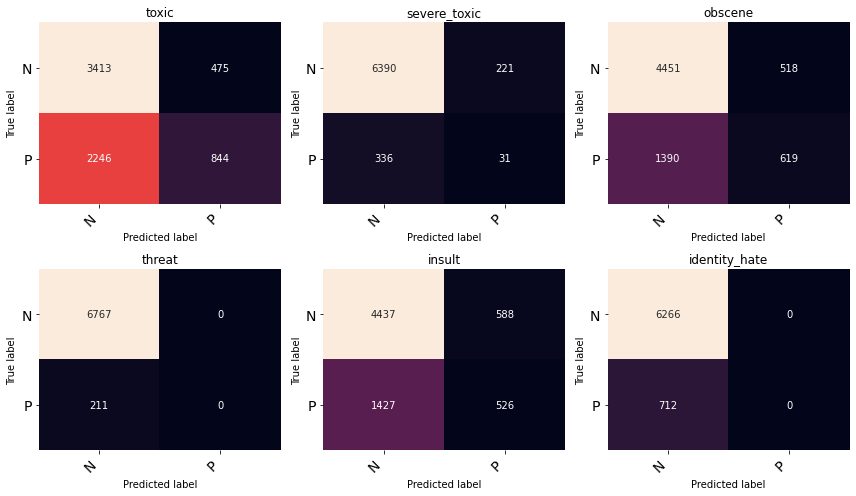

In [29]:
# Predictions
y_pred = l2.predict(l2_test_x)
y_pred_l2 = (y_pred > 0.5).astype("int32")

# Get confusion matrix
confusion_matrix = get_confusion_matrix(y_pred_l2)

# Get each confusion matrix by label
cm_list.append([cm.flatten() for cm in confusion_matrix])

# Get sum of confusion matrices by TFIDF
cm_sum = sum(confusion_matrix)
cm_list_tfidf.append(cm_sum.flatten())

# Add to dict
acc_dict['l2'] = get_accuracy(y_pred_l2)

# Plot confusion matrix
plot_confusion_matrix(confusion_matrix, labels)

## With smooth, without sublinear

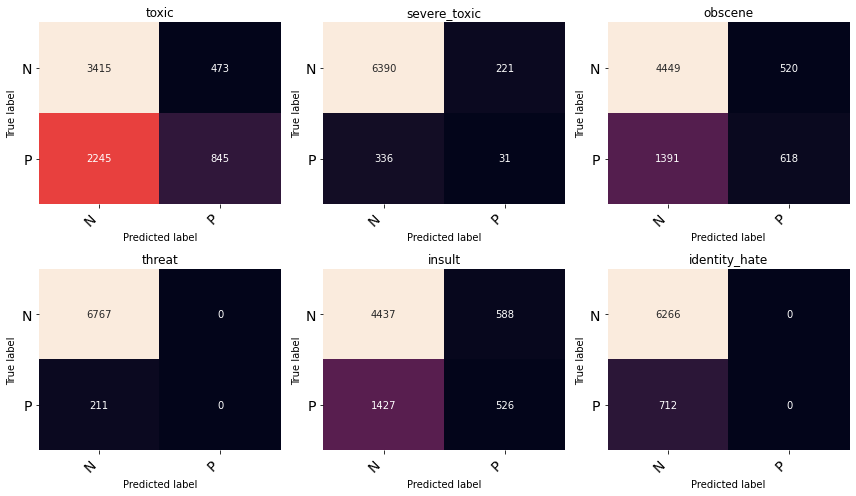

In [30]:
# Predictions
y_pred = l2.predict(l2_smooth_test_x)
y_pred_l2_smooth = (y_pred > 0.5).astype("int32")

# Get confusion matrix
confusion_matrix = get_confusion_matrix(y_pred_l2_smooth)

# Get each confusion matrix by label
cm_list.append([cm.flatten() for cm in confusion_matrix])

# Get sum of confusion matrices by TFIDF
cm_sum = sum(confusion_matrix)
cm_list_tfidf.append(cm_sum.flatten())

# Add to dict
acc_dict['l2_smooth'] = get_accuracy(y_pred_l2_smooth)

# Plot confusion matrix
plot_confusion_matrix(confusion_matrix, labels)

## Without smooth, with sublinear

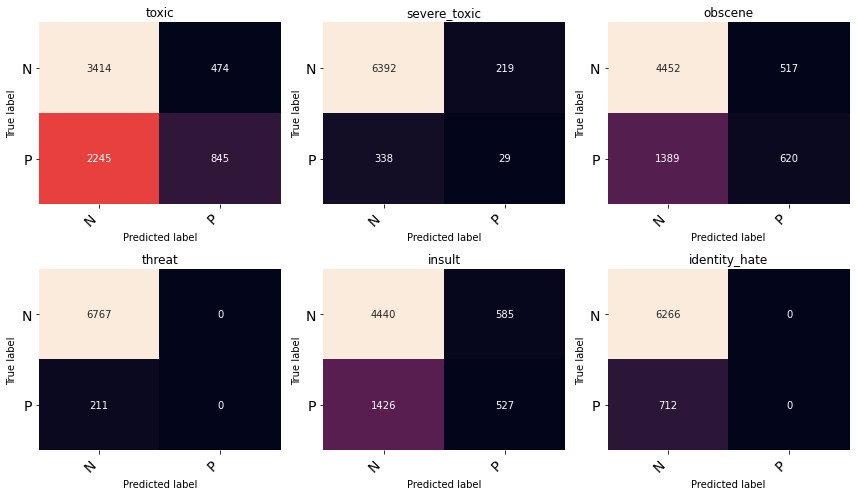

In [31]:
# Predictions
y_pred = l2.predict(l2_sub_test_x)
y_pred_l2_sub = (y_pred > 0.5).astype("int32")

# Get confusion matrix
confusion_matrix = get_confusion_matrix(y_pred_l2_sub)

# Get each confusion matrix by label
cm_list.append([cm.flatten() for cm in confusion_matrix])

# Get sum of confusion matrices by TFIDF
cm_sum = sum(confusion_matrix)
cm_list_tfidf.append(cm_sum.flatten())

# Add to dict
acc_dict['l2_sub'] = get_accuracy(y_pred_l2_sub)

# Plot confusion matrix
plot_confusion_matrix(confusion_matrix, labels)

## With both smooth and sublinear

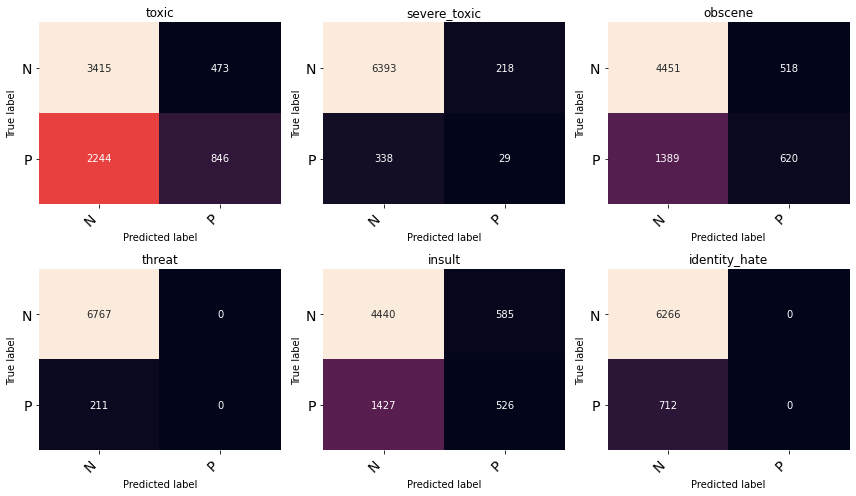

In [32]:
# Predictions
y_pred = l2.predict(l2_ss_test_x)
y_pred_l2_ss = (y_pred > 0.5).astype("int32")

# Get confusion matrix
confusion_matrix = get_confusion_matrix(y_pred_l2_ss)

# Get each confusion matrix by label
cm_list.append([cm.flatten() for cm in confusion_matrix])

# Get sum of confusion matrices by TFIDF
cm_sum = sum(confusion_matrix)
cm_list_tfidf.append(cm_sum.flatten())

# Add to dict
acc_dict['l2_ss'] = get_accuracy(y_pred_l2_ss)

# Plot confusion matrix
plot_confusion_matrix(confusion_matrix, labels)

# Normalization l1
## Without both smooth and sublinear

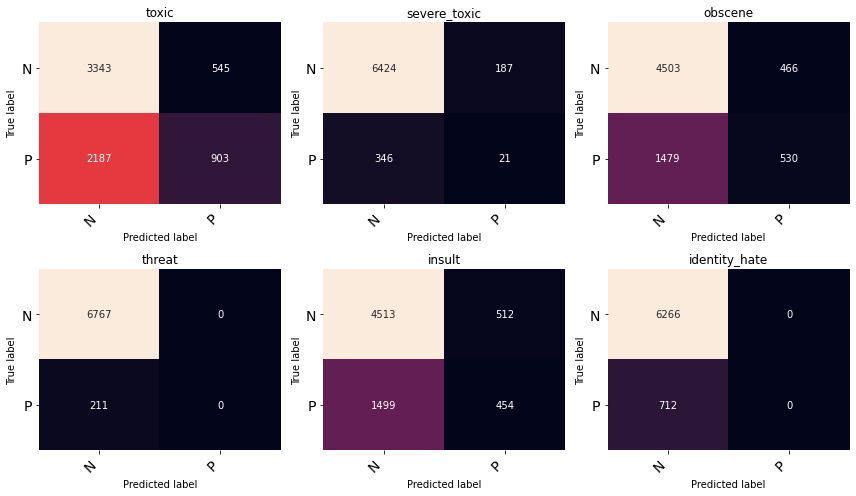

In [33]:
# Predictions
y_pred = l1.predict(l1_test_x)
y_pred_l1 = (y_pred > 0.5).astype("int32")

# Get confusion matrix
confusion_matrix = get_confusion_matrix(y_pred_l1)

# Get each confusion matrix by label
cm_list.append([cm.flatten() for cm in confusion_matrix])

# Get sum of confusion matrices by TFIDF
cm_sum = sum(confusion_matrix)
cm_list_tfidf.append(cm_sum.flatten())

# Add to dict
acc_dict['l1'] = get_accuracy(y_pred_l1)

# Plot confusion matrix
plot_confusion_matrix(confusion_matrix, labels)

## With smooth, without sublinear

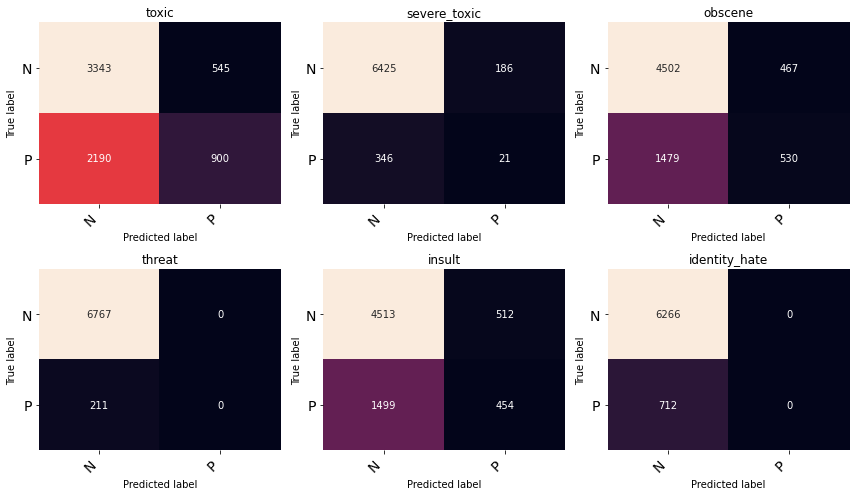

In [34]:
# Predictions
y_pred = l1.predict(l1_smooth_test_x)
y_pred_l1_smooth = (y_pred > 0.5).astype("int32")

# Get confusion matrix
confusion_matrix = get_confusion_matrix(y_pred_l1_smooth)

# Get each confusion matrix by label
cm_list.append([cm.flatten() for cm in confusion_matrix])

# Get sum of confusion matrices by TFIDF
cm_sum = sum(confusion_matrix)
cm_list_tfidf.append(cm_sum.flatten())

# Add to dict
acc_dict['l1_smooth'] = get_accuracy(y_pred_l1_smooth)

# Plot confusion matrix
plot_confusion_matrix(confusion_matrix, labels)

## Without smooth, with sublinear

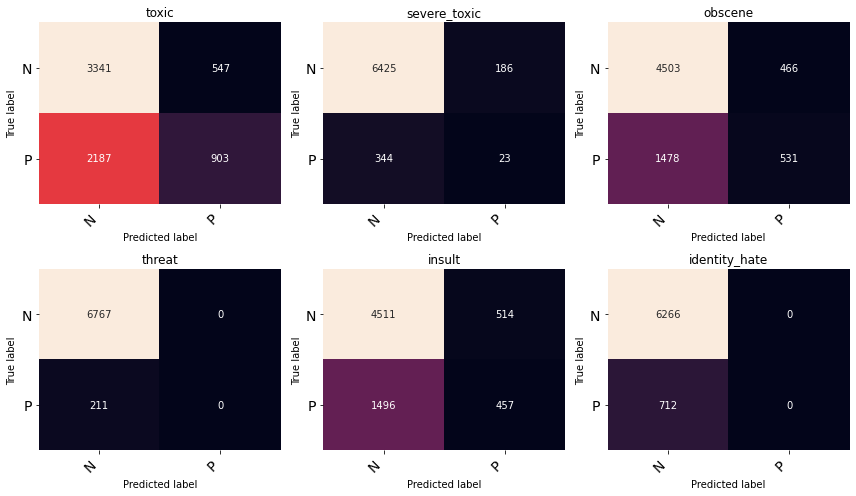

In [35]:
# Predictions
y_pred = l1.predict(l1_sub_test_x)
y_pred_l1_sub = (y_pred > 0.5).astype("int32")

# Get confusion matrix
confusion_matrix = get_confusion_matrix(y_pred_l1_sub)

# Get each confusion matrix by label
cm_list.append([cm.flatten() for cm in confusion_matrix])

# Get sum of confusion matrices by TFIDF
cm_sum = sum(confusion_matrix)
cm_list_tfidf.append(cm_sum.flatten())

# Add to dict
acc_dict['l1_sub'] = get_accuracy(y_pred_l1_sub)

# Plot confusion matrix
plot_confusion_matrix(confusion_matrix, labels)

## With both smooth and sublinear

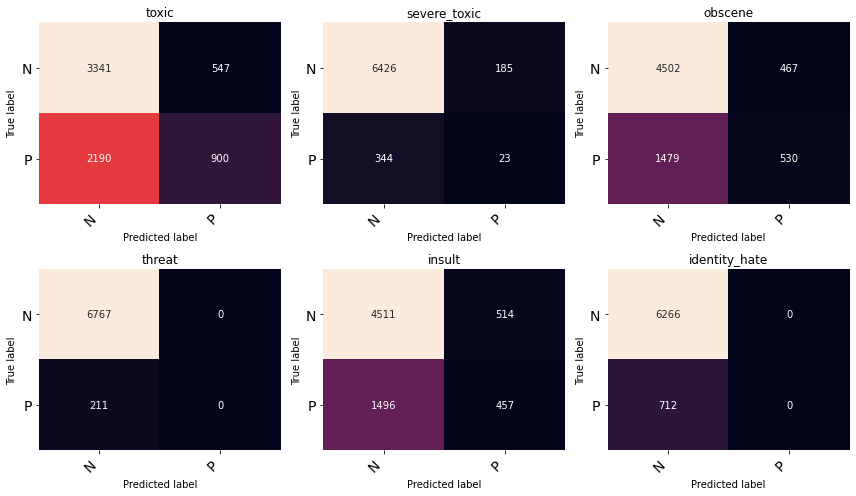

In [36]:
# Predictions
y_pred = l1.predict(l1_ss_test_x)
y_pred_l1_ss = (y_pred > 0.5).astype("int32")

# Get confusion matrix
confusion_matrix = get_confusion_matrix(y_pred_l1_ss)

# Get each confusion matrix by label
cm_list.append([cm.flatten() for cm in confusion_matrix])

# Get sum of confusion matrices by TFIDF
cm_sum = sum(confusion_matrix)
cm_list_tfidf.append(cm_sum.flatten())

# Add to dict
acc_dict['l1_ss'] = get_accuracy(y_pred_l1_ss)

# Plot confusion matrix
plot_confusion_matrix(confusion_matrix, labels)

I am unable to observe much from confusion matrices alone, as the results do not appear to differ greatly from each other.

# Comparing Confusion Matrices
## By label

In [37]:
# Plot a bar graph to show the number of TN, FP, FN, TP per label
# Params:
#   Int - @label_index: Item index of labels list
def plot_confusion_matrix_bar_graph(label_index, cm_list):

    # Label of bars
    tfidf_names = list(acc_dict.keys())
    # Colour of bars
    colours = ['pink', 'royalblue', 'orange', 'mediumseagreen', 'chocolate', 'blueviolet', 'red', 'tab:olive']
    # Confusion matrix list
    cm_list = np.asarray(cm_list)

    # 4 categories (Confusion matrix squares)
    n = 4
    r = np.arange(n)
    width = 0.1

    plt.figure(figsize=(15, 5))

    for i in range(len(tfidf_names)):

        plt.bar(
            r + width*i, 
            cm_list[i][label_index], # Bar data
            align='edge', 
            color=colours[i], 
            edgecolor='black', 
            label=tfidf_names[i], 
            width=width
        )

    plt.xlabel("Confusion Matrix Labels")
    plt.ylabel("Number of comments")
    plt.title("Confusion Matrix Values of label \'{0}\''".format(labels[label_index]))
    
    plt.xticks(r + width*4,['TN','FP','FN','TP'])
    plt.legend()
    
    plt.show()

# Plot a bar graph to show the number of TN, FP, FN, TP per TFIDF
# Params:
#   List - @cm_list_tfidf: List of confusion matrices sum by TFIDF
def plot_confusion_matrix_bar_tfidf(cm_list_tfidf):

    # Colour of bars
    colours = ['pink', 'royalblue', 'orange', 'mediumseagreen', 'chocolate', 'blueviolet', 'red', 'tab:olive']
    # Confusion matrix list
    cm_list = np.asarray(cm_list_tfidf)

    # 4 categories (Confusion matrix squares)
    n = 4
    r = np.arange(n)
    width = 0.1

    plt.figure(figsize=(15, 5))

    for i in range(len(tfidf_names)):

        plt.bar(
            r + width*i, 
            cm_list_tfidf[i], # Bar data
            align='edge', 
            color=colours[i], 
            edgecolor='black', 
            label=tfidf_names[i], 
            width=width
        )

    plt.xlabel("Confusion Matrix Labels")
    plt.ylabel("Number of comments")
    plt.title("Confusion Matrix Values of TFIDF Variations")
    
    plt.xticks(r + width*4,['TN','FP','FN','TP'])
    plt.legend()
    
    plt.show()

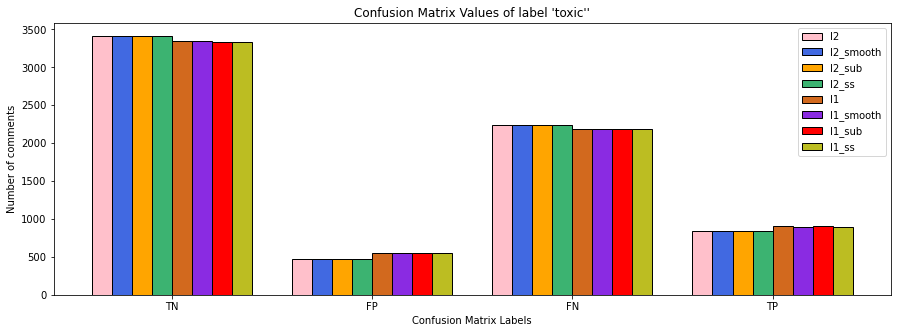

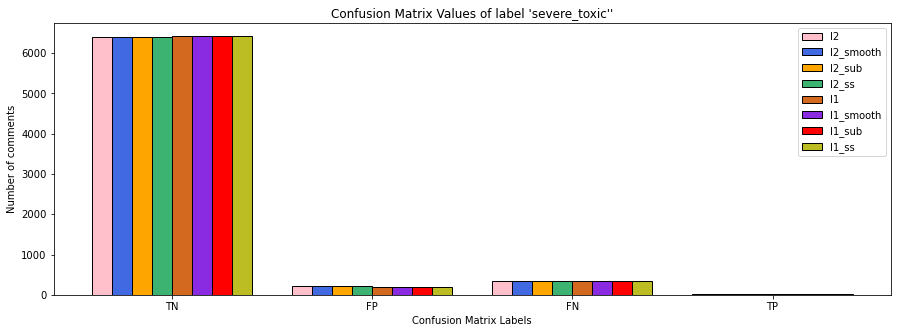

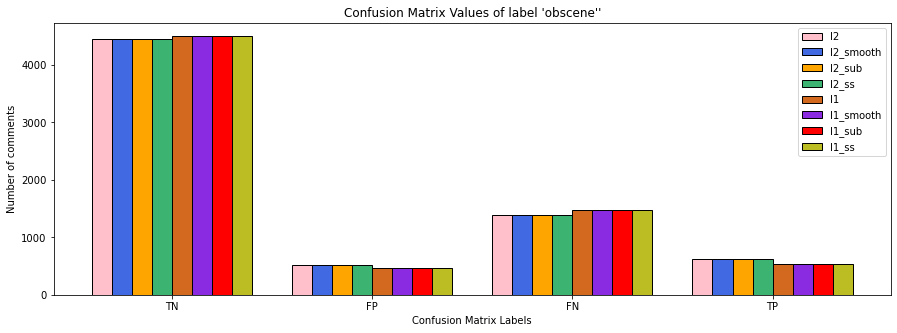

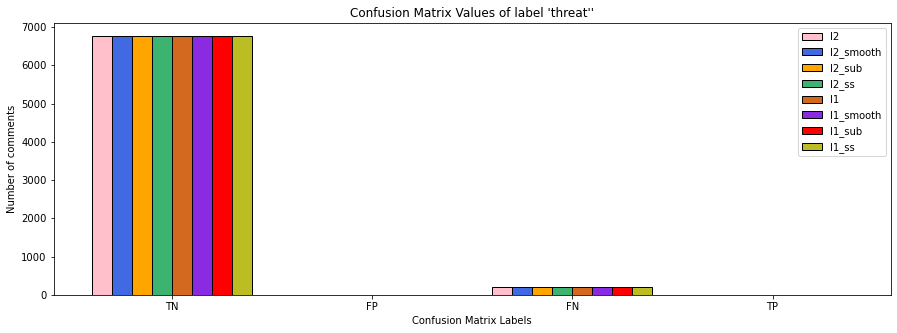

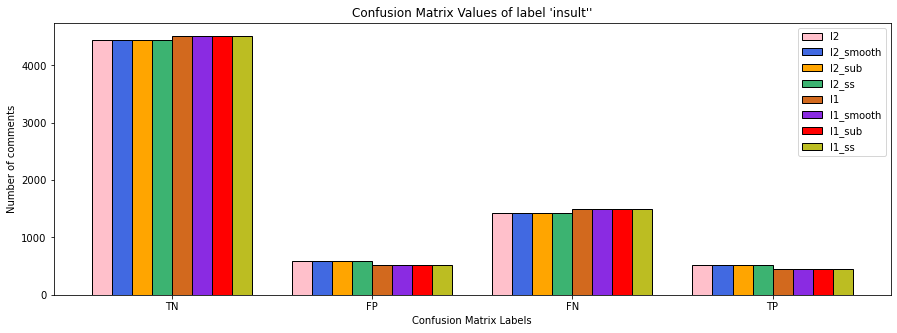

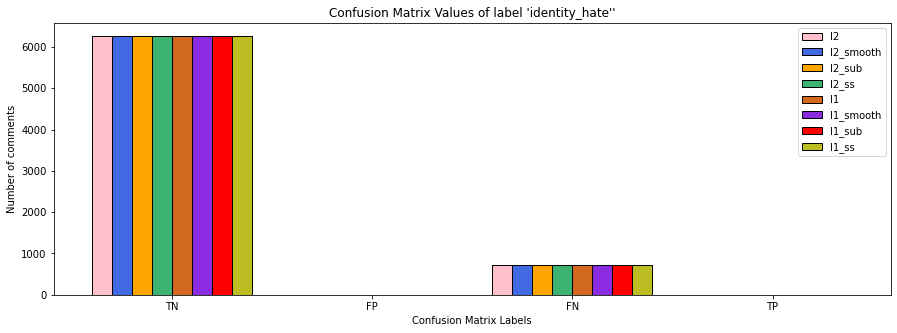

In [41]:
# Label of bars
tfidf_names = list(acc_dict.keys())

# Plot confusion matrix bar graph for every label
for i in range(len(labels)):
    plot_confusion_matrix_bar_graph(i, cm_list)

## By TFIDF Variation

I wanted to compare the confusion matrices of each TFIDF variation directly by summing every TN, FP, FN & TP value for each TFIDF. Since the objective of our classifier is to detect as many toxic comments as possible, I will be focusing on FP and TP (Precision).

At a glance, we can see that: 

* Normalization 'l1' has the highest TN values
* Normalization 'l2' has the highest FP values
* Normalization 'l2' + 'l1_sub' have the lowest FN values
* Normalization 'l2' has the highest TP values

Experimenting with smooth and sublinear did not seem to have a significant impact on the result.

To meet our objective, normalization 'l2' has the highest FP and TP rate.

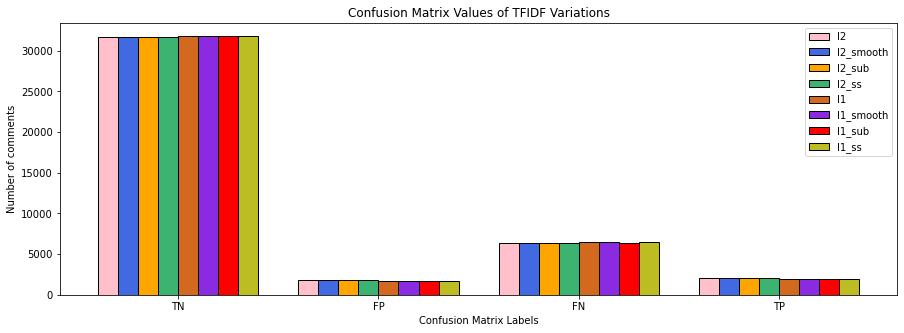

In [42]:
plot_confusion_matrix_bar_tfidf(cm_list_tfidf)

The values of each metric are very similar, so the bar graph is insufficient to show the results in detail. For that, I will be using a DataFrame, sorting by the highest TP.

In [43]:
cm_dict_tfidf = {}

for i in range(len(tfidf_names)):
    cm_dict_tfidf[tfidf_names[i]] = cm_list_tfidf[i]

cm_tfidf_df = pd.DataFrame.from_dict(cm_dict_tfidf, orient='index', columns=['TN', 'FP', 'FN', 'TP'])

sort_df = cm_tfidf_df.sort_values(by=['TP'], ascending=False)
print(sort_df)

              TN    FP    FN    TP
l2_sub     31731  1795  6321  2021
l2_ss      31732  1794  6321  2021
l2         31724  1802  6322  2020
l2_smooth  31724  1802  6322  2020
l1_sub     31813  1713  6428  1914
l1_ss      31813  1713  6432  1910
l1         31816  1710  6434  1908
l1_smooth  31816  1710  6437  1905


# Classification report metrics

It is apparent that **normalization l2** has the highest TP values. To compare the best TFIDF to use, I will be further comparing these 4 with sklearn's classification report.

In [46]:
from sklearn.metrics import classification_report

# l2
print("TFIDF l2")
print(classification_report(y_true, y_pred_l2, target_names=labels))
# l2_smooth
print("TFIDF l2_smooth")
print(classification_report(y_true, y_pred_l2_smooth, target_names=labels))
# l2_sub
print("TFIDF l2_sub")
print(classification_report(y_true, y_pred_l2_sub, target_names=labels))
# l2_ss
print("TFIDF l2_ss")
print(classification_report(y_true, y_pred_l2_ss, target_names=labels))

TFIDF l2
               precision    recall  f1-score   support

        toxic       0.64      0.27      0.38      3090
 severe_toxic       0.12      0.08      0.10       367
      obscene       0.54      0.31      0.39      2009
       threat       0.00      0.00      0.00       211
       insult       0.47      0.27      0.34      1953
identity_hate       0.00      0.00      0.00       712

    micro avg       0.53      0.24      0.33      8342
    macro avg       0.30      0.16      0.20      8342
 weighted avg       0.48      0.24      0.32      8342
  samples avg       0.10      0.11      0.10      8342

TFIDF l2_smooth
               precision    recall  f1-score   support

        toxic       0.64      0.27      0.38      3090
 severe_toxic       0.12      0.08      0.10       367
      obscene       0.54      0.31      0.39      2009
       threat       0.00      0.00      0.00       211
       insult       0.47      0.27      0.34      1953
identity_hate       0.00      0.00  

## F1-scores
As explained in xl00751_individual.ipynb , I will be focusing on the micro-averages of the F1-scores.

In [50]:
from sklearn.metrics import classification_report, f1_score

micro_f1 = {
    tfidf_names[0]: f1_score(y_true, y_pred_l2, average='micro'),
    tfidf_names[1]: f1_score(y_true, y_pred_l2_smooth, average='micro'),
    tfidf_names[2]: f1_score(y_true, y_pred_l2_sub, average='micro'),
    tfidf_names[3]: f1_score(y_true, y_pred_l2_ss, average='micro'),
}

micro_f1_df = pd.DataFrame.from_dict(micro_f1, orient='index', columns=['micro_f1_score'])
print(micro_f1_df.sort_values(by=['micro_f1_score'], ascending=False))

           micro_f1_score
l2_ss            0.332483
l2_sub           0.332456
l2               0.332128
l2_smooth        0.332128


The values are very similar, but **l2_ss** has the highest micro-average F1 score.

# Hamming Loss
I will be comparing the hamming losses of TFIDF normalization l2 to further evaluate the variations.

In [56]:
from sklearn.metrics import hamming_loss

# Get hamming losses for each TFIDF variation
def get_hamming_loss():

    hamming_losses = {
        tfidf_names[0]: hamming_loss(y_true, y_pred_l2),
        tfidf_names[1]: hamming_loss(y_true, y_pred_l2_smooth),
        tfidf_names[2]: hamming_loss(y_true, y_pred_l2_sub),
        tfidf_names[3]: hamming_loss(y_true, y_pred_l2_ss)
    }

    return hamming_losses

In [58]:
# Create dataframe
hamming_loss_df = pd.DataFrame.from_dict(get_hamming_loss(), orient='index', columns=['hamming_loss'])

print(hamming_loss_df.sort_values(by=['hamming_loss']))

           hamming_loss
l2_ss          0.193823
l2_sub         0.193847
l2             0.194038
l2_smooth      0.194038


Consistent with the micro-average F1-scores, **l2_ss** has the lowest hamming loss.

# Tensorflow Accuracy
Finally, I will be comparing the TFIDF normalization variations with tensorflow's accuracy, which calculates the number of predicted labels that match the true labels.

In [59]:
# Create dataframe
accuracy_df = pd.DataFrame.from_dict(acc_dict, orient='index', columns=['accuracy_score'])

print(accuracy_df.sort_values(by=['accuracy_score'], ascending=False))

           accuracy_score
l2_ss            0.806177
l2_sub           0.806153
l2               0.805962
l2_smooth        0.805962
l1_sub           0.805556
l1               0.805484
l1_ss            0.805460
l1_smooth        0.805412


It is clear that **l2_ss** has the best accuracy.

# Conclusion
Based on the evaluation methods of micro-averaged F1-scores, hamming losses and (Tensorflow) accuracy, TFIDF with normalization 'l2', with both smooth IDF and sublinear TF has the best results. This was consistent with my expectation that TFIDF with sublinear TF and smooth IDF would perform the best.

# Issues Faced
I did not face many issues with this experiment as TFIDF was straightforward to implement, thus there wasn't a need to adjust or retrain.